# MDE Manifold PCA/UMAP Viewer

The CSV + JSON describe an MDE run for one semantic category. This notebook always builds a 12-dimensional semantic category trajectory by stacking targets across category CSVs, and (optionally) also embeds ROI features for comparison using either the MDE-selected predictors or a full ROI lag stack.

In [1]:

# Update this path to point to the desired MDE input CSV
csv_path = "/flash/PaoU/seann/fmri-edm-ccm/figs_new/UTS01/wheretheressmoke/day26_smoothing_cli_MDE90step_detrend_gaussian_CAE/cat_abstract_/gauss_20p00/UTS01/wheretheressmoke/day22_category_mde/mde_cat_abstract_input_frame.csv"

if not csv_path.endswith("_input_frame.csv"):
    raise ValueError("Expected csv_path to end with '_input_frame.csv' so the JSON path can be inferred.")

json_path = csv_path.replace("_input_frame.csv", "_summary.json")

print(f"CSV path: {csv_path}")
print(f"JSON path: {json_path}")


CSV path: /flash/PaoU/seann/fmri-edm-ccm/figs_new/UTS01/wheretheressmoke/day26_smoothing_cli_MDE90step_detrend_gaussian_CAE/cat_abstract_/gauss_20p00/UTS01/wheretheressmoke/day22_category_mde/mde_cat_abstract_input_frame.csv
JSON path: /flash/PaoU/seann/fmri-edm-ccm/figs_new/UTS01/wheretheressmoke/day26_smoothing_cli_MDE90step_detrend_gaussian_CAE/cat_abstract_/gauss_20p00/UTS01/wheretheressmoke/day22_category_mde/mde_cat_abstract_summary.json


In [2]:

%matplotlib inline

import json
import glob
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401; ensures 3D projection is registered
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from sklearn.decomposition import PCA

try:
    from umap import UMAP
    UMAP_AVAILABLE = True
except ImportError:
    UMAP_AVAILABLE = False
    print("UMAP not installed. Install `pip install umap-learn` to enable UMAP embedding.")

np.random.seed(0)
plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams["figure.facecolor"] = "white"


In [3]:

# Choose matplotlib backend for interactive 3D rotation
# Options: "widget" (requires ipympl), "notebook" (built-in Jupyter interactivity), "inline" (static)
interactive_backend = "inline"

try:
    if interactive_backend == "widget":
        get_ipython().run_line_magic("matplotlib", "widget")
    elif interactive_backend == "notebook":
        get_ipython().run_line_magic("matplotlib", "notebook")
    else:
        get_ipython().run_line_magic("matplotlib", "inline")
    print(f"Matplotlib backend set to: {interactive_backend}")
except Exception as exc:
    print(f"Falling back to inline backend; requested {interactive_backend} failed: {exc}")
    get_ipython().run_line_magic("matplotlib", "inline")


Matplotlib backend set to: inline


In [4]:

if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV file not found: {csv_path}")
if not os.path.exists(json_path):
    raise FileNotFoundError(f"JSON file not found: {json_path}")

print("Loading data ...")
df = pd.read_csv(csv_path)
with open(json_path, "r") as f:
    meta = json.load(f)

selected_variables = meta.get("selected_variables")
if not selected_variables:
    raise ValueError("`selected_variables` is missing or empty in the metadata JSON.")

splits = meta.get("splits")
if not splits or not isinstance(splits, dict):
    raise ValueError("`splits` is missing or malformed in the metadata JSON; expected a dict with train/val/test.")

subject = meta.get("subject", "unknown_subject")
story = meta.get("story", "unknown_story")
target_column = meta.get("target_column", "target")

print(f"Loaded dataframe shape: {df.shape}")
print(f"Number of selected variables: {len(selected_variables)}")
for split_name in ("train", "val", "test"):
    print(f"{split_name} split indices: {splits.get(split_name)}")


Loading data ...
Loaded dataframe shape: (202, 36001)
Number of selected variables: 11
train split indices: [0, 101]
val split indices: [101, 151]
test split indices: [151, 202]


In [5]:
# Choose which ROI feature set to embed (semantic trajectory is always built separately)
# Options: "mde_selected" (default), "full_stack" (all ROI lags)
roi_feature_mode = "mde_selected"

# For "full_stack": set prefixes that identify ROI/lag columns (order follows the CSV column order)
full_stack_prefixes = []  # e.g., ["roi_", "lag_"]

# Legacy: semantic_prefixes retained for backwards compatibility but not used in semantic stacking
semantic_prefixes = []  # e.g., ["sem_", "bert", "gpt2"]

print(f"ROI feature mode: {roi_feature_mode}")
if roi_feature_mode == "full_stack":
    print(f"Full stack prefixes: {full_stack_prefixes}")


ROI feature mode: mde_selected


In [6]:
# Optional lag cap for full_stack mode (None means no cap).
# Set to an integer to keep only columns whose lag index <= this value.
# Lag index is parsed from the last integer found in the column name (e.g., 'roi_12_lag3' -> 3).
max_lag_index = None  # e.g., 3


In [7]:
# Semantic configuration (always used to build semantic trajectories)
semantic_parent_dir = "/flash/PaoU/seann/fmri-edm-ccm/figs_new/UTS01/wheretheressmoke/day26_smoothing_cli_MDE90step_detrend_gaussian_CAE"
semantic_smoothing_label = "gauss_5p00"  # e.g., gauss_20p00, gauss_40p00

semantic_categories = [
    "abstract",
    "communal",
    "emotional",
    "locational",
    "mental",
    "numeric",
    "professional",
    "social",
    "tactile",
    "temporal",
    "violent",
    "visual",
]

print(f"Semantic parent dir: {semantic_parent_dir}")
print(f"Semantic smoothing label: {semantic_smoothing_label}")
print(f"Semantic categories: {semantic_categories}")


Semantic parent dir: /flash/PaoU/seann/fmri-edm-ccm/figs_new/UTS01/wheretheressmoke/day26_smoothing_cli_MDE90step_detrend_gaussian_CAE
Semantic smoothing label: gauss_5p00
Semantic categories: ['abstract', 'communal', 'emotional', 'locational', 'mental', 'numeric', 'professional', 'social', 'tactile', 'temporal', 'violent', 'visual']


In [8]:
# Build semantic category trajectories (always run)
print("Building semantic category trajectories from per-category CSV targets...")
df_semantic = None
T_sem = None
for name in semantic_categories:
    pattern = os.path.join(
        semantic_parent_dir,
        f"cat_{name}_",
        semantic_smoothing_label,
        "*",
        "*",
        "day22_category_mde",
        f"mde_cat_{name}_input_frame.csv",
    )
    matches = glob.glob(pattern)
    if len(matches) == 0:
        raise FileNotFoundError(f"No files matched for category '{name}' with pattern {pattern}")
    if len(matches) > 1:
        raise RuntimeError(f"Multiple matches for category '{name}': {matches}")
    df_cat = pd.read_csv(matches[0])
    if "target" not in df_cat.columns:
        raise ValueError(f"Category '{name}' CSV is missing a 'target' column: {matches[0]}")
    if T_sem is None:
        T_sem = len(df_cat)
        if T_sem != len(df):
            raise ValueError(
                f"Category '{name}' length {T_sem} does not match base CSV length {len(df)}; splits would misalign."
            )
        df_semantic = pd.DataFrame(index=range(T_sem))
    else:
        if len(df_cat) != T_sem:
            raise ValueError(
                f"Category '{name}' length {len(df_cat)} does not match expected length {T_sem}."
            )
    df_semantic[f"cat_{name}"] = df_cat["target"].to_numpy()
df_semantic = df_semantic.rename_axis(None)
X_semantic = df_semantic.to_numpy(dtype=float)
print(f"Semantic trajectory shape (T, D): {X_semantic.shape}")
print(f"Semantic categories stacked: {list(df_semantic.columns)}")


Building semantic category trajectories from per-category CSV targets...
Semantic trajectory shape (T, D): (202, 12)
Semantic categories stacked: ['cat_abstract', 'cat_communal', 'cat_emotional', 'cat_locational', 'cat_mental', 'cat_numeric', 'cat_professional', 'cat_social', 'cat_tactile', 'cat_temporal', 'cat_violent', 'cat_visual']


In [9]:
# Standardize semantic trajectories
sem_means_before = X_semantic.mean(axis=0)
sem_std_before = X_semantic.std(axis=0, ddof=0)
sem_std_safe = np.where(sem_std_before == 0, 1.0, sem_std_before)
X_semantic_std = (X_semantic - sem_means_before) / sem_std_safe
sem_means_after = X_semantic_std.mean(axis=0)
sem_std_after = X_semantic_std.std(axis=0, ddof=0)
print(f"Semantic mean before: min={sem_means_before.min():.4f}, max={sem_means_before.max():.4f}")
print(f"Semantic std before: min={sem_std_before.min():.4f}, max={sem_std_before.max():.4f}")
print(f"Semantic mean after: min={sem_means_after.min():.4f}, max={sem_means_after.max():.4f}")
print(f"Semantic std after: min={sem_std_after.min():.4f}, max={sem_std_after.max():.4f}")


Semantic mean before: min=-0.0183, max=0.0194
Semantic std before: min=0.9082, max=1.0639
Semantic mean after: min=-0.0000, max=0.0000
Semantic std after: min=1.0000, max=1.0000


In [10]:
# PCA on semantic trajectories
pca_sem = PCA(n_components=3, random_state=0)
X_sem_pca3 = pca_sem.fit_transform(X_semantic_std)
explained_sem = pca_sem.explained_variance_ratio_
cumulative_sem = explained_sem.cumsum()
print(f"Semantic PCA explained variance ratio: {explained_sem}")
print(f"Semantic cumulative variance explained (3 comps): {cumulative_sem[-1]:.4f}")


Semantic PCA explained variance ratio: [0.49388862 0.30788049 0.15786819]
Semantic cumulative variance explained (3 comps): 0.9596


In [11]:
# Build time and split labels for semantic trajectories
T_sem = X_sem_pca3.shape[0]
time_idx_sem = np.arange(T_sem)
split_labels_sem = np.full(T_sem, "other", dtype=object)

def apply_split_sem(name, rng):
    if rng is None:
        return
    if not (isinstance(rng, (list, tuple)) and len(rng) == 2):
        raise ValueError(f"Split '{name}' should be a [start, end] pair.")
    start, end = int(rng[0]), int(rng[1])
    if start < 0 or end > T_sem or start > end:
        raise ValueError(f"Split '{name}' range {rng} is out of bounds for T={T_sem}.")
    split_labels_sem[start:end] = name

for split_name in ("train", "val", "test"):
    apply_split_sem(split_name, splits.get(split_name))
unique_sem, counts_sem = np.unique(split_labels_sem, return_counts=True)
print(f"Semantic split label counts: {dict(zip(unique_sem, counts_sem))}")


Semantic split label counts: {'test': np.int64(51), 'train': np.int64(101), 'val': np.int64(50)}


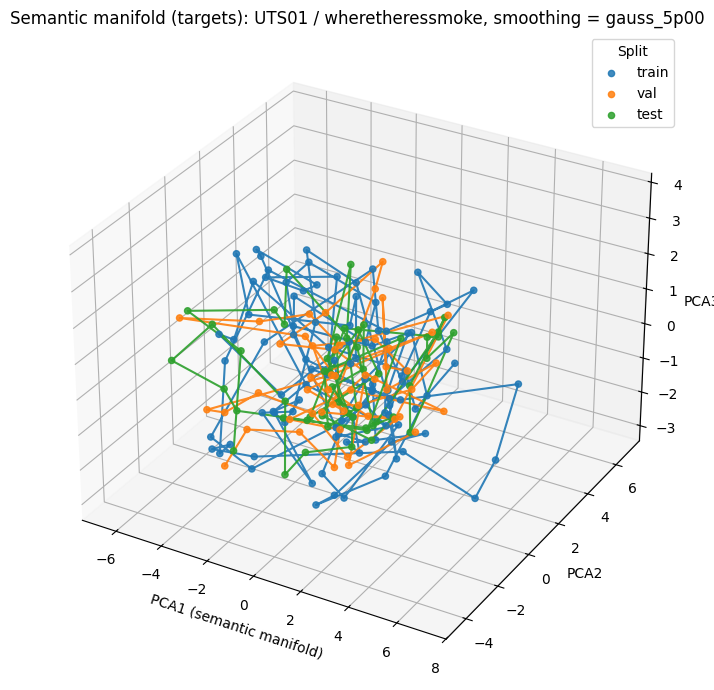

In [12]:
# Semantic PCA manifold plot colored by split
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")
label_colors = {"train": "tab:blue", "val": "tab:orange", "test": "tab:green", "other": "0.7"}
for label, color in label_colors.items():
    mask = split_labels_sem == label
    if mask.any():
        ax.scatter(
            X_sem_pca3[mask, 0],
            X_sem_pca3[mask, 1],
            X_sem_pca3[mask, 2],
            label=label,
            s=20,
            alpha=0.85,
            c=color,
        )
        if mask.sum() > 1:
            ordered_idx = np.where(mask)[0]
            ax.plot(
                X_sem_pca3[ordered_idx, 0],
                X_sem_pca3[ordered_idx, 1],
                X_sem_pca3[ordered_idx, 2],
                color=color,
                linewidth=1.5,
                alpha=0.9,
            )
ax.set_xlabel("PCA1 (semantic manifold)")
ax.set_ylabel("PCA2")
ax.set_zlabel("PCA3")
ax.set_title(f"Semantic manifold (targets): {subject} / {story}, smoothing = {semantic_smoothing_label}")
ax.legend(title="Split", loc="best")
plt.tight_layout()


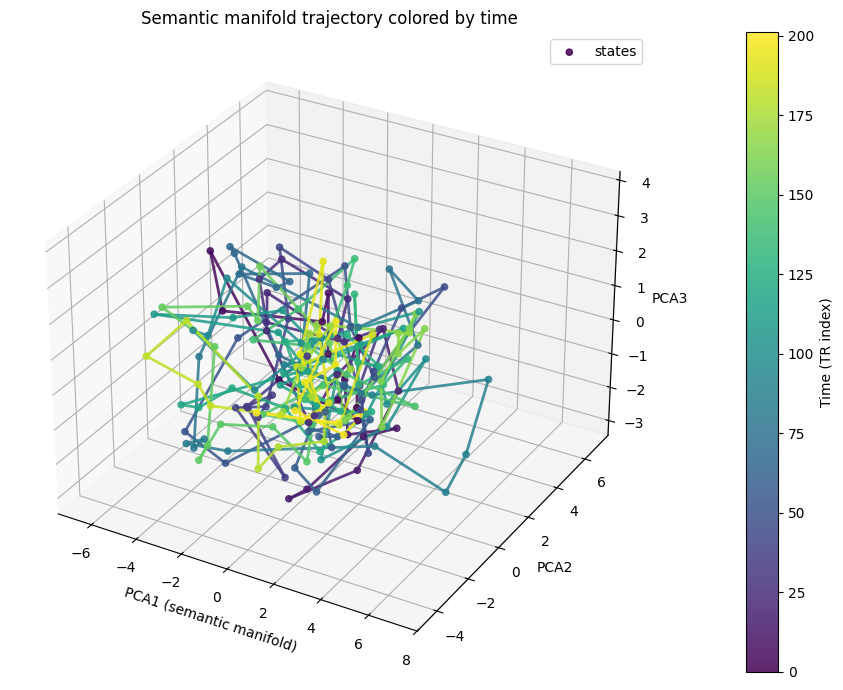

In [13]:
# Semantic PCA manifold plot colored by time
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")
if X_sem_pca3.shape[0] > 1:
    segments = np.stack([X_sem_pca3[:-1], X_sem_pca3[1:]], axis=1)
    lc = Line3DCollection(segments, cmap="viridis", linewidths=2, alpha=0.85)
    lc.set_array(time_idx_sem[:-1])
    ax.add_collection3d(lc)
scatter = ax.scatter(
    X_sem_pca3[:, 0],
    X_sem_pca3[:, 1],
    X_sem_pca3[:, 2],
    c=time_idx_sem,
    cmap="viridis",
    s=20,
    alpha=0.85,
    label="states",
)
ax.set_xlabel("PCA1 (semantic manifold)")
ax.set_ylabel("PCA2")
ax.set_zlabel("PCA3")
ax.set_title("Semantic manifold trajectory colored by time")
cb = fig.colorbar(scatter, ax=ax, pad=0.1)
cb.set_label("Time (TR index)")
ax.legend(loc="best")
plt.tight_layout()


In [14]:
# Build the ROI state-space matrix

df_features = df.copy()
if "target" in df_features.columns:
    df_features = df_features.drop(columns=["target"])

def collect_by_prefix(columns, prefixes):
    return [col for col in columns if any(col.startswith(p) for p in prefixes)]

def deduplicate(seq):
    seen = set()
    return [x for x in seq if not (x in seen or seen.add(x))]

def parse_lag_index(name):
    nums = re.findall(r'(\d+)', name)
    return int(nums[-1]) if nums else None

if roi_feature_mode == "mde_selected":
    feature_columns = deduplicate(selected_variables)
    missing_cols = [col for col in feature_columns if col not in df_features.columns]
    if missing_cols:
        raise ValueError(f"Missing expected columns in CSV: {missing_cols}")
    df_mde = df_features[feature_columns]
    X_mde = df_mde.to_numpy(dtype=float)
elif roi_feature_mode == "full_stack":
    if not full_stack_prefixes:
        raise ValueError("Set full_stack_prefixes to capture the full ROI lag stack.")
    feature_columns = deduplicate(collect_by_prefix(df_features.columns, full_stack_prefixes))
    if max_lag_index is not None:
        filtered = []
        for col in feature_columns:
            lag_val = parse_lag_index(col)
            if lag_val is None or lag_val <= max_lag_index:
                filtered.append(col)
        feature_columns = filtered
    if not feature_columns:
        raise ValueError(f"No columns matched full_stack_prefixes={full_stack_prefixes} after lag filtering.")
    df_mde = df_features[feature_columns]
    X_mde = df_mde.to_numpy(dtype=float)
else:
    raise ValueError("roi_feature_mode must be one of ['mde_selected', 'full_stack'].")

print(f"ROI feature mode: {roi_feature_mode}")
if roi_feature_mode == "full_stack":
    print(f"Lag cap (max_lag_index): {max_lag_index}")
print(f"Number of ROI features used: {X_mde.shape[1]}")
print(f"ROI state-space matrix shape (T, D): {X_mde.shape}")


ROI feature mode: mde_selected
Number of ROI features used: 11
ROI state-space matrix shape (T, D): (202, 11)


In [15]:

# Optional standardization to improve PCA stability

means_before = X_mde.mean(axis=0)
std_before = X_mde.std(axis=0, ddof=0)
std_safe = np.where(std_before == 0, 1.0, std_before)

X_mde_std = (X_mde - means_before) / std_safe

means_after = X_mde_std.mean(axis=0)
std_after = X_mde_std.std(axis=0, ddof=0)

print(f"Mean before standardization: min={means_before.min():.4f}, max={means_before.max():.4f}")
print(f"Std before standardization: min={std_before.min():.4f}, max={std_before.max():.4f}")
print(f"Mean after standardization: min={means_after.min():.4f}, max={means_after.max():.4f}")
print(f"Std after standardization: min={std_after.min():.4f}, max={std_after.max():.4f}")


Mean before standardization: min=-0.0639, max=0.0521
Std before standardization: min=0.9607, max=1.1144
Mean after standardization: min=-0.0000, max=0.0000
Std after standardization: min=1.0000, max=1.0000


PCA below is used only to project the high-dimensional MDE state-space into 3D for visualization; it does not alter the underlying MDE model or forecasting performance.

In [16]:

# Fit PCA and project to 3 dimensions

pca = PCA(n_components=3, random_state=0)
X_pca3 = pca.fit_transform(X_mde_std)

explained_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_ratio.cumsum()

print(f"Explained variance ratio: {explained_ratio}")
print(f"Cumulative variance explained (3 components): {cumulative_variance[-1]:.4f}")


Explained variance ratio: [0.16571058 0.14127236 0.11796793]
Cumulative variance explained (3 components): 0.4250


### PCA adequacy quick take
- Current PCA explains only ~40% (e.g., ~16.6%, 14.1%, 11.8%), so 3D view is a blurry slice of the manifold.
- Scatter looks roughly isotropic (no loops/curvature/flow), consistent with linear PCA flattening nonlinear structure.
- MDE embeddings are nonlinear (lags + nonlinear transforms), so linear PCA under-represents folding/twisting dynamics.
- Next step: try a nonlinear embedder (e.g., UMAP) to reveal cycles/branches/slow manifold structure in the trajectory.

In [17]:

# Build time and split labels

T = X_pca3.shape[0]
time_idx = np.arange(T)
split_labels = np.full(T, "other", dtype=object)


def apply_split(name, rng):
    if rng is None:
        return
    if not (isinstance(rng, (list, tuple)) and len(rng) == 2):
        raise ValueError(f"Split '{name}' should be a [start, end] pair.")
    start, end = int(rng[0]), int(rng[1])
    if start < 0 or end > T or start > end:
        raise ValueError(f"Split '{name}' range {rng} is out of bounds for T={T}.")
    split_labels[start:end] = name


for split_name in ("train", "val", "test"):
    apply_split(split_name, splits.get(split_name))

unique, counts = np.unique(split_labels, return_counts=True)
print(f"Split label counts: {dict(zip(unique, counts))}")


Split label counts: {'test': np.int64(51), 'train': np.int64(101), 'val': np.int64(50)}


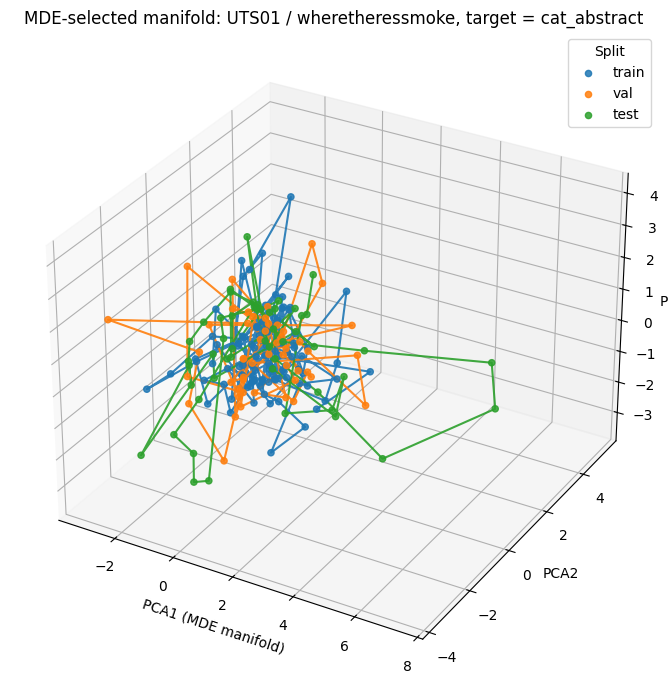

In [18]:

# 3D manifold plot colored by split

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

label_colors = {"train": "tab:blue", "val": "tab:orange", "test": "tab:green", "other": "0.7"}
for label, color in label_colors.items():
    mask = split_labels == label
    if mask.any():
        ax.scatter(
            X_pca3[mask, 0],
            X_pca3[mask, 1],
            X_pca3[mask, 2],
            label=label,
            s=20,
            alpha=0.85,
            c=color,
        )
        if mask.sum() > 1:
            ordered_idx = np.where(mask)[0]
            ax.plot(
                X_pca3[ordered_idx, 0],
                X_pca3[ordered_idx, 1],
                X_pca3[ordered_idx, 2],
                color=color,
                linewidth=1.5,
                alpha=0.9,
            )

ax.set_xlabel("PCA1 (MDE manifold)")
ax.set_ylabel("PCA2")
ax.set_zlabel("PCA3")
ax.set_title(f"MDE-selected manifold: {subject} / {story}, target = {target_column}")
ax.legend(title="Split", loc="best")
plt.tight_layout()


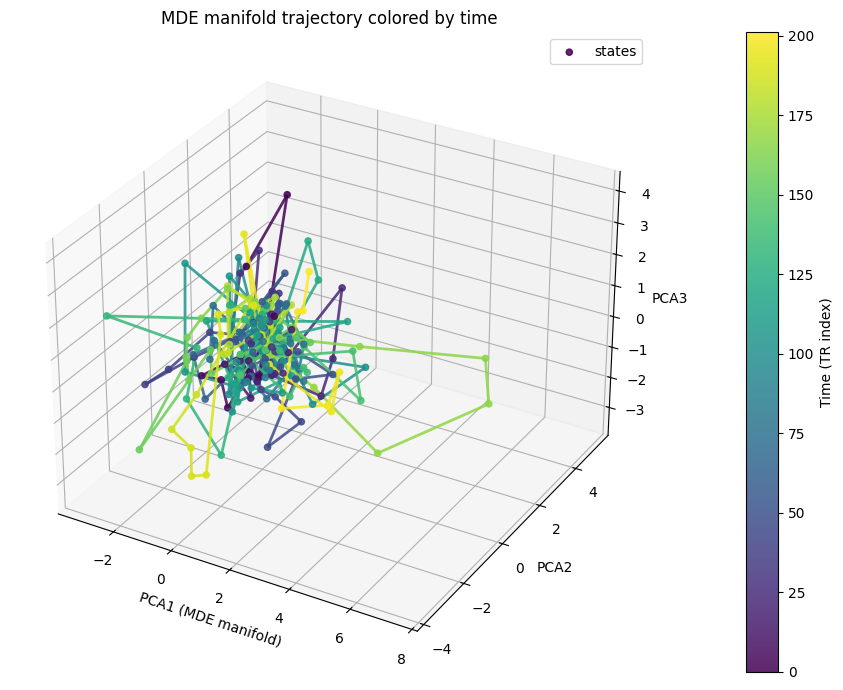

In [19]:

# 3D manifold plot colored by time

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

if X_pca3.shape[0] > 1:
    segments = np.stack([X_pca3[:-1], X_pca3[1:]], axis=1)
    lc = Line3DCollection(segments, cmap="viridis", linewidths=2, alpha=0.85)
    lc.set_array(time_idx[:-1])
    ax.add_collection3d(lc)

scatter = ax.scatter(
    X_pca3[:, 0],
    X_pca3[:, 1],
    X_pca3[:, 2],
    c=time_idx,
    cmap="viridis",
    s=20,
    alpha=0.85,
    label="states",
)

ax.set_xlabel("PCA1 (MDE manifold)")
ax.set_ylabel("PCA2")
ax.set_zlabel("PCA3")
ax.set_title("MDE manifold trajectory colored by time")
cb = fig.colorbar(scatter, ax=ax, pad=0.1)
cb.set_label("Time (TR index)")
ax.legend(loc="best")
plt.tight_layout()


### UMAP (nonlinear manifold view)
Defaults here are tuned for ~200 TRs (n_neighbors=10, min_dist=0.01) to emphasize local structure.
Optional time augmentation keeps adjacent TRs close in the embedding; set time_weight=0 to disable.

In [20]:

# UMAP hyperparameters and optional time-aware augmentation
umap_params = dict(
    n_components=3,
    n_neighbors=17,  # try 5-15 if you want more/less local structure 
    #semantics #2 #5 #10 #16 #17 #27 #29 #32
    #MDE selected #2 #10 #20 #nothing too interesting
    min_dist=0.01,   # try 0.0-0.05 to stretch/compact the trajectory
    metric="euclidean",
    random_state=0,
)

# Set to 0 to disable time-aware smoothing; 0.1-1.0 encourages consecutive TRs to stay neighbors
time_weight = 0.5


In [21]:
# UMAP for semantic trajectories

if not UMAP_AVAILABLE:
    raise ImportError("Install `umap-learn` to run the UMAP embedding cells.")

X_sem_umap_input = X_semantic_std
if time_weight and time_idx_sem.max() > 0:
    time_scaled_sem = (time_idx_sem / time_idx_sem.max())[:, None]
    X_sem_umap_input = np.hstack([X_semantic_std, time_weight * time_scaled_sem])
    print(f"Using time-augmented features for semantic UMAP with weight={time_weight}.")
else:
    print("Using feature-only semantic UMAP (no time augmentation).")

umap_model_sem = UMAP(**umap_params)
X_sem_umap3 = umap_model_sem.fit_transform(X_sem_umap_input)

print(f"Semantic UMAP embedding shape (T, 3): {X_sem_umap3.shape}")
print(f"Semantic UMAP params -> {umap_params}")


Using time-augmented features for semantic UMAP with weight=0.5.


/flash/PaoU/seann/fmri-edm-ccm/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Semantic UMAP embedding shape (T, 3): (202, 3)
Semantic UMAP params -> {'n_components': 3, 'n_neighbors': 17, 'min_dist': 0.01, 'metric': 'euclidean', 'random_state': 0}


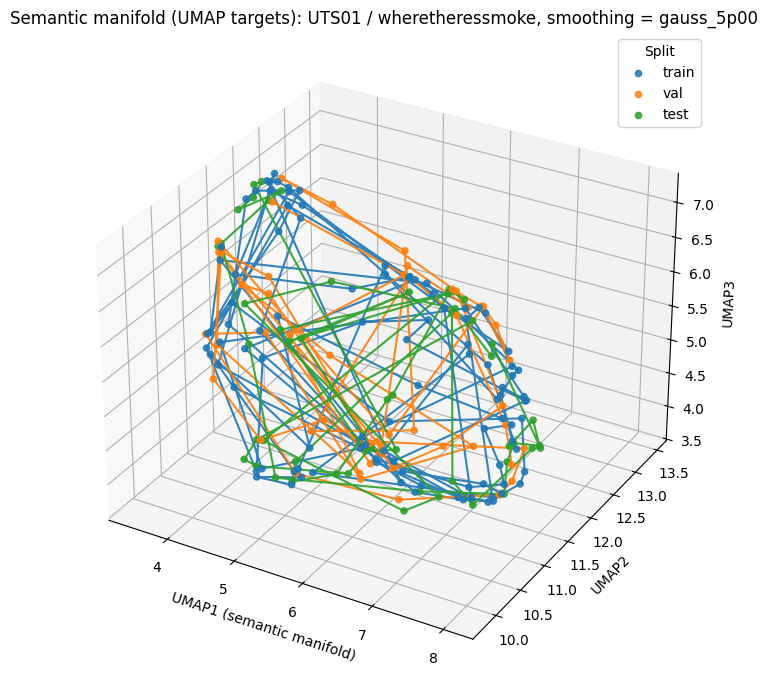

In [22]:
# Semantic UMAP manifold plot colored by split

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")
label_colors = {"train": "tab:blue", "val": "tab:orange", "test": "tab:green", "other": "0.7"}
for label, color in label_colors.items():
    mask = split_labels_sem == label
    if mask.any():
        ax.scatter(
            X_sem_umap3[mask, 0],
            X_sem_umap3[mask, 1],
            X_sem_umap3[mask, 2],
            label=label,
            s=20,
            alpha=0.85,
            c=color,
        )
        if mask.sum() > 1:
            ordered_idx = np.where(mask)[0]
            ax.plot(
                X_sem_umap3[ordered_idx, 0],
                X_sem_umap3[ordered_idx, 1],
                X_sem_umap3[ordered_idx, 2],
                color=color,
                linewidth=1.5,
                alpha=0.9,
            )
ax.set_xlabel("UMAP1 (semantic manifold)")
ax.set_ylabel("UMAP2")
ax.set_zlabel("UMAP3")
ax.set_title(f"Semantic manifold (UMAP targets): {subject} / {story}, smoothing = {semantic_smoothing_label}")
ax.legend(title="Split", loc="best")
plt.tight_layout()


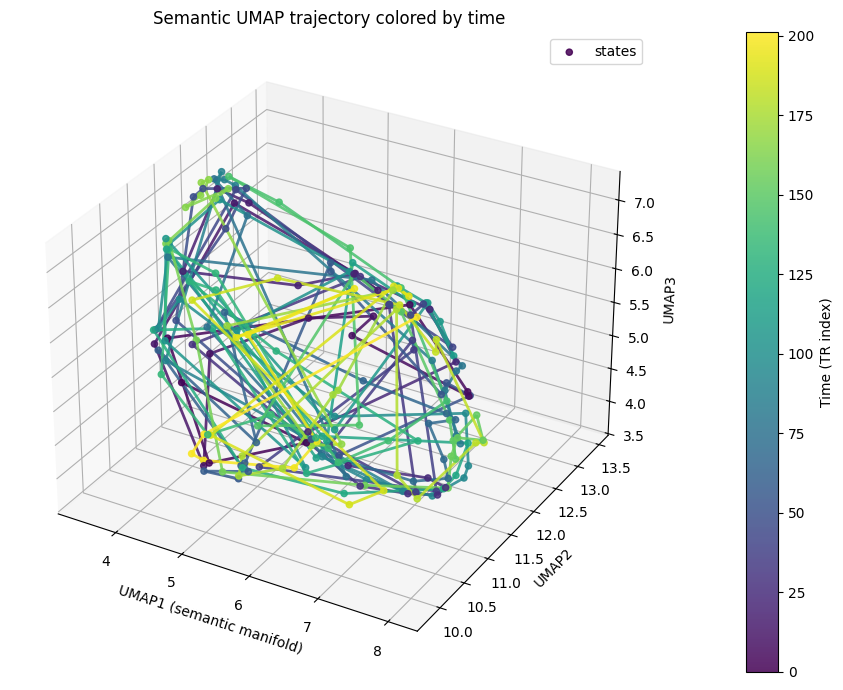

In [23]:
# Semantic UMAP manifold plot colored by time

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")
if X_sem_umap3.shape[0] > 1:
    segments = np.stack([X_sem_umap3[:-1], X_sem_umap3[1:]], axis=1)
    lc = Line3DCollection(segments, cmap="viridis", linewidths=2, alpha=0.85)
    lc.set_array(time_idx_sem[:-1])
    ax.add_collection3d(lc)
scatter = ax.scatter(
    X_sem_umap3[:, 0],
    X_sem_umap3[:, 1],
    X_sem_umap3[:, 2],
    c=time_idx_sem,
    cmap="viridis",
    s=20,
    alpha=0.85,
    label="states",
)
ax.set_xlabel("UMAP1 (semantic manifold)")
ax.set_ylabel("UMAP2")
ax.set_zlabel("UMAP3")
ax.set_title("Semantic UMAP trajectory colored by time")
cb = fig.colorbar(scatter, ax=ax, pad=0.1)
cb.set_label("Time (TR index)")
ax.legend(loc="best")
plt.tight_layout()


In [24]:

# Fit UMAP and project to 3 dimensions

if not UMAP_AVAILABLE:
    raise ImportError("Install `umap-learn` to run the UMAP embedding cells.")

X_umap_input = X_mde_std
if time_weight and time_idx.max() > 0:
    time_scaled = (time_idx / time_idx.max())[:, None]
    X_umap_input = np.hstack([X_mde_std, time_weight * time_scaled])
    print(f"Using time-augmented features for UMAP with weight={time_weight}.")
else:
    print("Using feature-only UMAP (no time augmentation).")

umap_model = UMAP(**umap_params)
X_umap3 = umap_model.fit_transform(X_umap_input)

print(f"UMAP embedding shape (T, 3): {X_umap3.shape}")
print(f"UMAP params -> {umap_params}")


Using time-augmented features for UMAP with weight=0.5.


/flash/PaoU/seann/fmri-edm-ccm/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP embedding shape (T, 3): (202, 3)
UMAP params -> {'n_components': 3, 'n_neighbors': 17, 'min_dist': 0.01, 'metric': 'euclidean', 'random_state': 0}


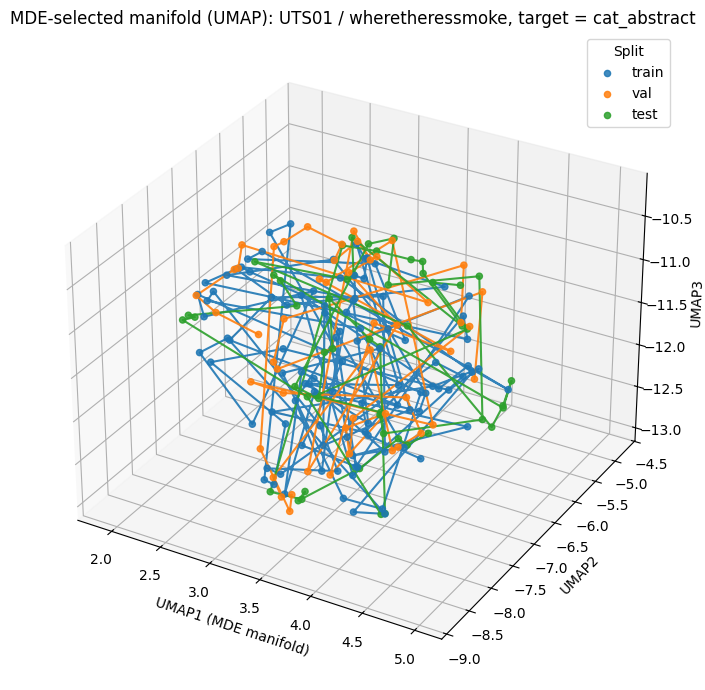

In [25]:

# UMAP 3D manifold plot colored by split

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

label_colors = {"train": "tab:blue", "val": "tab:orange", "test": "tab:green", "other": "0.7"}
for label, color in label_colors.items():
    mask = split_labels == label
    if mask.any():
        ax.scatter(
            X_umap3[mask, 0],
            X_umap3[mask, 1],
            X_umap3[mask, 2],
            label=label,
            s=20,
            alpha=0.85,
            c=color,
        )
        if mask.sum() > 1:
            ordered_idx = np.where(mask)[0]
            ax.plot(
                X_umap3[ordered_idx, 0],
                X_umap3[ordered_idx, 1],
                X_umap3[ordered_idx, 2],
                color=color,
                linewidth=1.5,
                alpha=0.9,
            )

ax.set_xlabel("UMAP1 (MDE manifold)")
ax.set_ylabel("UMAP2")
ax.set_zlabel("UMAP3")
ax.set_title(f"MDE-selected manifold (UMAP): {subject} / {story}, target = {target_column}")
ax.legend(title="Split", loc="best")
plt.tight_layout()


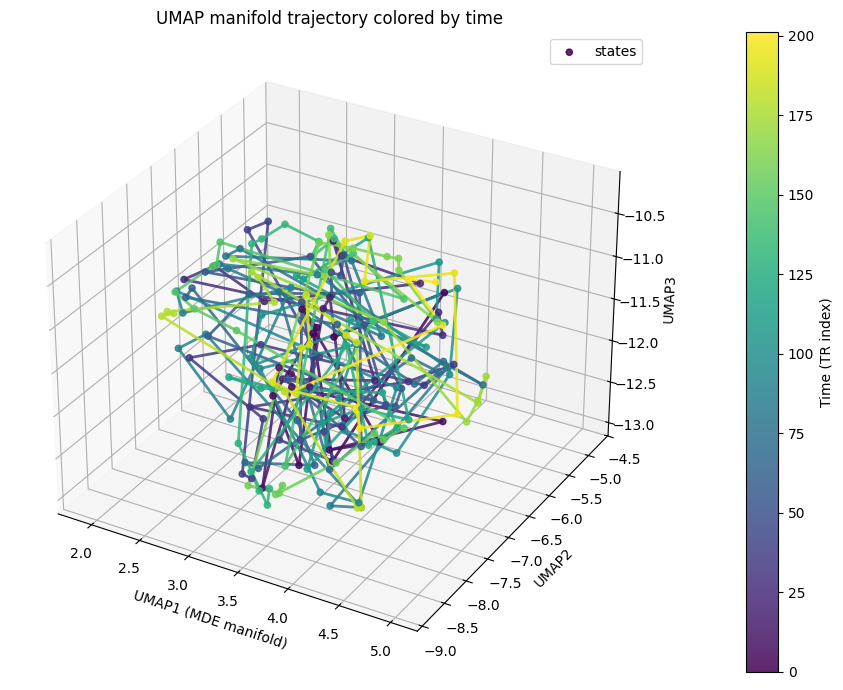

In [26]:

# UMAP 3D manifold plot colored by time

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

if X_umap3.shape[0] > 1:
    segments = np.stack([X_umap3[:-1], X_umap3[1:]], axis=1)
    lc = Line3DCollection(segments, cmap="viridis", linewidths=2, alpha=0.85)
    lc.set_array(time_idx[:-1])
    ax.add_collection3d(lc)

scatter = ax.scatter(
    X_umap3[:, 0],
    X_umap3[:, 1],
    X_umap3[:, 2],
    c=time_idx,
    cmap="viridis",
    s=20,
    alpha=0.85,
    label="states",
)

ax.set_xlabel("UMAP1 (MDE manifold)")
ax.set_ylabel("UMAP2")
ax.set_zlabel("UMAP3")
ax.set_title("UMAP manifold trajectory colored by time")
cb = fig.colorbar(scatter, ax=ax, pad=0.1)
cb.set_label("Time (TR index)")
ax.legend(loc="best")
plt.tight_layout()
